## Assignment Week 7

### Fine-Tuning

LLM fine-tuning is a technique to adjust the wights of a LLM to make it generate tailored response for a specific task without the hassle of training and building a LLM from scratch. Fine tuning requires preparation of the task specific dataset, fine tune the model and then evaluate the performance of the fine-tuned model for qualitative and quantitative metrics.

``` Prepare dataset >> Load dataset to OpenAI >> Start Fine Tuning Job >> Run test```

In the assignment, we are fine-tuning Open AI `gpt-4o-mini` model so that it can act as an assistant which replies answers with emojis but instead of emoji it should reply **with words**.

For example, if we ask about about a smiling face instead of 😀, it must respond with `(grinningface)`.

1. Prepare Dataset

Open AI fine tuning expects jsonl format with each line containing example with messages similar to [chat completion api format][1] (example below). It is a list of messages where each message has a role, content, and optional name. 

```
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?"}]}
{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters."}]}
```
Data prepration is not required for this assignment because we are using already curated dataset from the author (Bahree, 2024) that follows the above jsonl format.

[1]:https://platform.openai.com/docs/api-reference/chat/createm
[2]:https://github.com/bahree/GenAIBook/tree/main/chapters/ch09/data

In [18]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

import numpy as np
import tiktoken  
import os
import pprint
import time

In [2]:
MAX_TOKENS = 65536

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 10000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 5

##### Basic data check

In [95]:
# def basic_checks(data_file):
#     try:
#         with open(data_file, "r", encoding="utf-8") as f:
#             dataset = [json.loads(line) for line in f]

#         print(f"Basic checks for file {data_file}:")
#         print("Count of examples in training dataset:", len(dataset))
#         print("First example:")
#         for message in dataset[0]["messages"]:
#             print(message)
#         return True
#     except FileNotFoundError as e:
#         print(f"File not found error occurred in file {data_file}: {e}")
#         return False
#     except json.JSONDecodeError as e:
#         print(f"JSON decoding error occurred in file {data_file}: {e}")
#         return False
#     except Exception as e:
#         print(f"An error occurred in file {data_file}: {e}")
#         return False

In [3]:
training_data_file = "./datasets/emoji_ft_train.jsonl"
validation_data_file = "./datasets/emoji_ft_validation.jsonl"

In [4]:
# if not basic_checks(training_data_file):
#     print(f"Error in Trainingfile {training_data_file}")
# if not basic_checks(validation_data_file):
#     print(f"Error in Validation file {validation_data_file}")

The training and validation files have passed the check for `jsonl` format 

##### Token validation

`gpt-4o-mini-2024-07-18` will be used as foundational model for fine-tuning, so to get the correct token counts, the encoding corresponding to this model must be used.

In [6]:
# get the encoding for gpt-4o-mini-2024-07-18
encoding = tiktoken.encoding_for_model("gpt-4o-mini-2024-07-18")
print(f"Token encoding for gpt-4o-mini is : {encoding.name}")

Token encoding for gpt-4o-mini is : o200k_base


In [5]:
# def format_checks(dataset, filename):
#     # Initialize a dictionary, used to track format errors
#     format_errors = defaultdict(int)

#     # Iterate over each example in the dataset
#     for ex in dataset:
#         # Check if the example is a dictionary, if not 
#         # increment the corresponding error count
#         if not isinstance(ex, dict):
#             format_errors["data_type"] += 1
#             continue

#         # Check if the example has a "messages" key, 
#         # if not increment the corresponding error count
#         messages = ex.get("messages", None)
#         if not messages:
#             format_errors["missing_messages_list"] += 1
#             continue

#         # Iterate over each message in the messages list
#         for message in messages:
#             # Check if the message has "role" and "content" keys,
#             # if not increment the corresponding error count
#             if "role" not in message or "content" not in message:
#                 format_errors["message_missing_key"] += 1

#             # Check if the message has any unrecognized keys,
#             # if so increment the corresponding error count
#             if any(k not in ("role", "content", "name", "function_call") for k in message):
#                 format_errors["message_unrecognized_key"] += 1

#             # Check if the role of the message is one of the recognized
#             # roles, if not increment the corresponding error count
#             if message.get("role", None) not in (
#                 "system",
#                 "user",
#                 "assistant",
#                 "function",
#             ):
#                 format_errors["unrecognized_role"] += 1

#             # Check if the message has either content or a function call,
#             # and if the content is a string, if not increment the
#             # corresponding error count
#             content = message.get("content", None)
#             function_call = message.get("function_call", None)
#             if (not content and not function_call) or not isinstance(content, str):
#                 format_errors["missing_content"] += 1

#         # Check if there is at least one message with the role "assistant",
#         # if not increment the corresponding error count
#         if not any(message.get("role", None) == "assistant" for message in messages):
#             format_errors["example_missing_assistant_message"] += 1

#     # If there are any format errors, print them and return False
#     if format_errors:
#         print(f"Formatting errors found in file {filename}:")
#         for k, v in format_errors.items():
#             print(f"{k}: {v}")
#         return False
#     print(f"No formatting errors found in file {filename}")
#     return True

In [7]:
# check example format are correct for training file
# with open(training_data_file, "r", encoding="utf-8") as f:
#     train_dataset = [json.loads(line) for line in f]
#     if not format_checks(train_dataset, training_data_file):
#         print(f"Error in training examples format validation for {training_data_file}")

In [8]:
# check example format are correct for validation file
# with open(validation_data_file, "r", encoding="utf-8") as f:
#     valid_dataset = [json.loads(line) for line in f]
#     if not format_checks(valid_dataset, validation_data_file):
#         print(f"Error in training examples format validation for {validation_data_file}")

Fine tuning is billed by the `number of tokens` used in the training examples. Hence, it is always advisable to estimate the numbers tokens in the training examples and how many total tokens will be used in the fine-tuning. This will provide a rough estimate about the cost of the fine-tuning to avoid any surprises.

In [9]:
# Print the number of tokens in the messages
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

# print the number of tokens in the assistant messages
def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens


In [10]:
# Estimate the number of tokens that will be charged for during training
def estimate_tokens(dataset, assistant_tokens):
    # Set the initial number of epochs to the target epochs
    n_epochs = TARGET_EPOCHS
    
    # Get the number of examples in the dataset
    n_train_examples = len(dataset)

    # If the examples total is less than the minimum target
    # adjust the epochs to ensure we have enough examples for
    # training
    if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
        n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
    
    # If the  number of examples is more than the maximum target
    # adjust the  epochs to ensure we don't exceed the maximum 
    # for training
    elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
        n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

    # Calculate the total number of tokens in the dataset
    # n_billing_tokens_in_dataset = sum(min(MAX_TOKENS, length) for length in assistant_tokens)
    n_billing_tokens_in_dataset = sum(min(MAX_TOKENS, length) for length in assistant_tokens)

    # Print the total token count that will be charged during training
    print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")

    # Print the default number of epochs for training
    print(f"You will train for {n_epochs} epochs on this dataset")

    # Print the total number of tokens that will be charged during training
    print(f"You will be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

    # If the total token count exceeds the maximum tokens, print a warning 
    if n_billing_tokens_in_dataset > MAX_TOKENS:
        print(f"WARNING: Your dataset contains examples longer than 4K tokens by {n_billing_tokens_in_dataset - MAX_TOKENS} tokens.")
        print("You will be charged for the full length of these examples during training, but only the first 4K tokens will be used for training.")
    return n_billing_tokens_in_dataset

In [12]:
with open(training_data_file, "r", encoding="utf-8") as f:
    train_dataset = [json.loads(line) for line in f]
with open(validation_data_file, "r", encoding="utf-8") as f:
    valid_dataset = [json.loads(line) for line in f]

In [13]:
total_tokens = []
assistant_tokens = []
for example in train_dataset:
    messages = example.get("messages", {})
    total_tokens.append(num_tokens_from_messages(messages))
    assistant_tokens.append(num_assistant_tokens_from_messages(messages))

In [16]:
tokens_used_in_traiing = estimate_tokens(train_dataset, total_tokens)

Dataset has ~19522 tokens that will be charged for during training
You will train for 3 epochs on this dataset
You will be charged for ~58566 tokens


In [17]:
print(f"Estimated Cost: $ {(3/1000000)*tokens_used_in_traiing*TARGET_EPOCHS}")

Estimated Cost: $ 0.175698


OpenAI doesnot charge for validation tokens, so only training tokens are charged. Current pricing is \$3 per 1M tokens. For the above training dataset the estimated cost is `$0.18`

2. Upload training file to Open AI

Open AI requires the training and validation file to be uploaded in OpenAI file storage for training.

In [117]:
# get api key from file
with open("../../apikeys/openai-keys.json", "r") as key_file:
    api_key = json.load(key_file)["default_api_key"]
os.environ["OPENAI_API_KEY"] = api_key

In [118]:
# Upload training file
from openai import OpenAI
client = OpenAI()

response = client.files.create(
  file=open(training_data_file, "rb"),
  purpose="fine-tune"
)

In [121]:
print("Uploaded file details\n",response)

Uploaded file details
 FileObject(id='file-LXx1cigU9wSjnU7urUBiUb', bytes=119751, created_at=1737307365, filename='emoji_ft_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


In [122]:
# upload validation file
validation_file_response = client.files.create(
  file=open(validation_data_file, "rb"),
  purpose="fine-tune"
)
print("Uploaded file details\n",validation_file_response)

Uploaded file details
 FileObject(id='file-KE6JVSUfZSWx8ShsRu1sca', bytes=2053, created_at=1737308416, filename='emoji_ft_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


3. Create and start Fine tuning job

In [123]:
ft_job = client.fine_tuning.jobs.create(
    training_file="file-LXx1cigU9wSjnU7urUBiUb",
    validation_file="file-KE6JVSUfZSWx8ShsRu1sca",
    model="gpt-4o-mini-2024-07-18",
    suffix="emoji-20240122",
    hyperparameters={
        "n_epochs":3
    },
)

print("Finetuning job details:\n", ft_job)

Finetuning job details:
 FineTuningJob(id='ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2', created_at=1737308522, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=3), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-i0HGnyzXyYOGEdOd7p2dDDri', result_files=[], seed=918569459, status='validating_files', trained_tokens=None, training_file='file-LXx1cigU9wSjnU7urUBiUb', validation_file='file-KE6JVSUfZSWx8ShsRu1sca', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=3)), type='supervised'), user_provided_suffix='emoji-20240122')


In [124]:
# List 10 fine-tuning jobs
# ft_job_list = client.fine_tuning.jobs.list()

In [129]:
# Retrieve the state of a fine-tune
start_time = time.time()
while True:
    job = client.fine_tuning.jobs.retrieve("ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2")
    print(job.id, job.status)
    if job.status in ["succeeded","failed","cancelled"]:
        print(f"Job Status: {job.status}")
        print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))
        break
    time.sleep(60)

ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2 running
ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2 running
ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2 running
ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2 running
ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2 succeeded
Job Status: succeeded
Elapsed time: 97 minutes 1 seconds


Open AI fine tuning job stores the fine-tuning metrics in a result file. The file-id of the resut file can be reference by retriveing the job details in `result_files` attribute.

In [131]:
#retrive the result file id and model name of the model
result = client.fine_tuning.jobs.retrieve("ftjob-c2mZjQSpX7Kd2rrhwnxNOKw2")
print(f"Model id: {result.fine_tuned_model}\nResult file id: {result.result_files}")

Model id: ft:gpt-4o-mini-2024-07-18:personal:emoji-20240122:ArUCgSFs
Result file id: ['file-R7nTQzxG7tD3sR9hQuVwmL']


In [132]:
# Retrive file content from the fine tuning job results
from openai import OpenAI
client = OpenAI()

ft_results = client.files.content(result.result_files[0])

The results are `base-64` encoded, so it needs to be decoded for use and can be downloaded as csv.

In [146]:
import base64

string_bytes = base64.b64decode(ft_results.content)
result_string = string_bytes.decode("ascii")

with open("./results.csv","w") as outfile:
    outfile.write(result_string)
    


Using pandas to read the reslts csv file and plotting the training and validation loss curves

In [147]:
import pandas as pd

In [161]:
df = pd.read_csv("./results.csv")

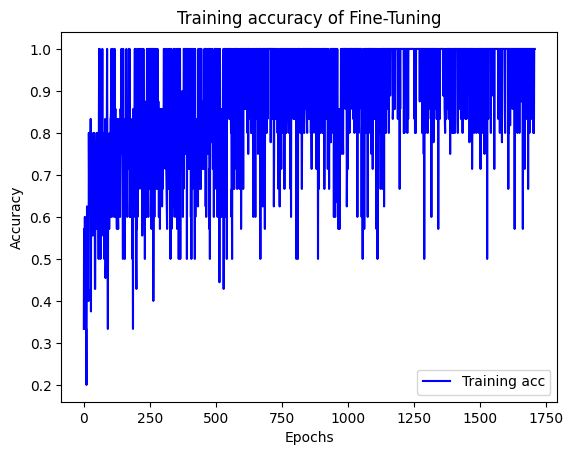

In [164]:
# plot the training accuracy
plt.plot(df["step"], df["train_accuracy"], 'b-', label='Training acc')
plt.title('Training accuracy of Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

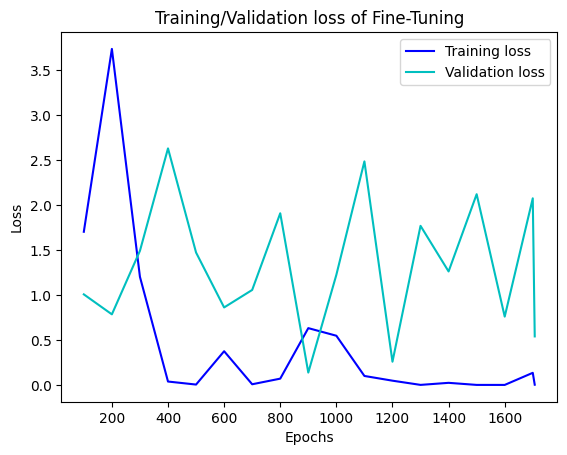

In [169]:
# Plot the training loss and validation loss
plt.plot(df["step"], df["train_loss"], 'b-', label='Training loss')
df = df[df["valid_loss"].notna()]
plt.plot(df["step"], df["valid_loss"], 'c-', label='Validation loss')
plt.title('Training/Validation loss of Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


The above curve shows a promising training with training loss high and then stabilizing near zero as number of iterations increses. We do not notice a similar pattern with validation loss as it do not reduce near zero with number of iterations. This may be indication of ovefitting as ideally the training loss and validation loss must be close to each other towards the end of iterations. 

Now the model is ready for testing.

4. Testing the fine tuned model

Prompt 1: Enjoying snowfall

In [3]:
# get api key from file
with open("../../apikeys/openai-keys.json", "r") as key_file:
    api_key = json.load(key_file)["default_api_key"]
os.environ["OPENAI_API_KEY"] = api_key

In [4]:
from openai import OpenAI
client = OpenAI()

#### GPT 4o mini without fine-tuning

In [5]:
messages=[
        {
            "role": "system", 
            "content": f"You are a assistant that generates emojis\n\
            If you donot know the answer, simply state that you donot know."
        },
        {
            "role": "user", 
            "content": f"Q: Enjoying snowfall\nA:"
        }
    ]

In [7]:
chat_response_1_std = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages
)
print(f"Response from GPT 4o mini without fine-tuning:\n {chat_response_1_std.choices[0].message.content}")

Response from GPT 4o mini without fine-tuning:
 ❄️☃️🌨️✨


#### Fine-tuned Model

In [8]:
chat_response_1_fine_tuned = client.chat.completions.create(
    model="ft:gpt-4o-mini-2024-07-18:personal:emoji-20240122:ArUCgSFs",
    messages=messages
)
print(f"Response from GPT 4o mini without fine-tuning:\n {chat_response_1_fine_tuned.choices[0].message.content}")

Response from GPT 4o mini without fine-tuning:
 (cloudwithsnow)


In [3]:
# get api key from file
with open("../../apikeys/openai-keys.json", "r") as key_file:
    api_key = json.load(key_file)["default_api_key"]
os.environ["OPENAI_API_KEY"] = api_key

In [4]:
from openai import OpenAI
client = OpenAI()

Prompt 2: Celebrating graduation

#### GPT 4o mini without fine-tuning

In [9]:
messages=[
        {
            "role": "system", 
            "content": f"You are a assistant that generates emojis\n\
            If you donot know the answer, simply state that you donot know."
        },
        {
            "role": "user", 
            "content": f"Q: Celebrating graduation\nA:"
        }
    ]

In [10]:
chat_response_2_std = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages
)
print(f"Response from GPT 4o mini without fine-tuning:\n {chat_response_2_std.choices[0].message.content}")

Response from GPT 4o mini without fine-tuning:
 🎓🎉🎊🥳📚✨


#### Fine-tuned Model

In [11]:
chat_response_2_fine_tuned = client.chat.completions.create(
    model="ft:gpt-4o-mini-2024-07-18:personal:emoji-20240122:ArUCgSFs",
    messages=messages
)
print(f"Response from the fine-tuning model:\n {chat_response_2_fine_tuned.choices[0].message.content}")

Response from GPT 4o mini without fine-tuning:
 (graduationcap)
